# **Instrucciones para examen**

**Objetivo:** Este examen tiene como objetivo evaluar la capacidad del estudiante para limpiar, explorar, implementar y evaluar modelos de clasificación en un dataset de diabetes. Utilizaremos el «Diabetes Dataset» disponible en Kaggle. Los estudiantes deben demostrar habilidades prácticas en la manipulación de datos, creación de visualizaciones y modelado predictivo.

## **Contexto y Descripción del Dataset**

El «Diabetes Dataset» contiene datos de salud de mujeres de ascendencia indígena Pima que viven cerca de Phoenix, Arizona, EE.UU. La tarea es predecir si un paciente tiene diabetes o no, basándose en ciertas medidas diagnósticas incluidas en el dataset.

**Diccionario de Datos:**

**Pregnancies:** Número de embarazos.

**Glucose:** Concentración de glucosa en plasma a las 2 horas en una prueba oral de tolerancia a la glucosa.

**BloodPressure:** Presión arterial diastólica (mm Hg).

**SkinThickness:** Espesor del pliegue cutáneo del tríceps (mm).

**Insulin:** Niveles séricos de insulina a las 2 horas (mu U/ml).

**BMI:** Índice de masa corporal (peso en kg / (altura en m)^2).

**DiabetesPedigreeFunction:** Función de pedigrí de diabetes.

**Age:** Edad (años).

**Outcome:** Variable objetivo (1: diabetes, 0: no diabetes).


# **Importamos librerias y cargamos el dataset Diabetes**

In [36]:
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


path = '../data/diabetes.csv'
df = pd.read_csv(path)

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## **Limpieza de datos**

In [2]:
# Exploramos las columnas del dataset para reconocer las variables con las que trabajamos
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Vemos informacion basica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### **Conversion de tipos de datos**

In [4]:
# Convertimos Outcome, variale binaria a tipo boleano
df['Outcome'] = df['Outcome'].astype(bool)
print(df['Outcome'].dtype)

bool


### **Intentificacion de duplicados**

In [5]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


### **Verificacion de datos faltantes**

In [6]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

# Fuente: Clase de Manejo de valores nulo

,datos sin NAs en q,Na en q,Na en %
Pregnancies,768,0,0.0
Glucose,768,0,0.0
BloodPressure,768,0,0.0
SkinThickness,768,0,0.0
Insulin,768,0,0.0
BMI,768,0,0.0
DiabetesPedigreeFunction,768,0,0.0
Age,768,0,0.0
Outcome,768,0,0.0


### **Verificacion de outliners y tratamos los valores zeros**

#### **Tratamos los valores con Zero**

Imputamos los zeros de la columnas Glucose, Blood Pressure, SkinTchickness, Insulin, BMI usando un modelo de regresion linear debido a que estamos tratando con datos medicas. Con la regresion llenamos los valores en zeros, con valores predicidos en base a pacientes con caracteristicas similares. 

In [7]:
# Verificamos la cantidad de valores zero por columna. Determinamos que columnas puedan tener errores en los datos y necestan imputacion
def count_zero_values(df):
    zero_counts = df.eq(0).sum()
    return zero_counts

zero_counts = count_zero_values(df)
print("Number of zeros per column:")
print(zero_counts)

Number of zeros per column:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [ ]:
# Suprimos los waring ya que generan mucho cloread en el codigo
warnings.filterwarnings('ignore')

# Crear una copia del DataFrame para no modificar el original
data_imputed = df.copy()

# Lista de columnas con valores 0 que queremos imputar
columns_to_impute = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Glucose']

# Creamos un loop con las columnas para imputar valores 0 usando un modelo de regresion linear
for column in columns_to_impute:
    # Crear el modelo de regresión
    model = LinearRegression()
    
    # Seleccionar las filas donde la columna no es 0
    train_data = data_imputed[data_imputed[column] != 0]
    X_train = train_data.drop(columns_to_impute, axis=1)  
    y_train = train_data[column]
    
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Seleccionar las filas donde la columna es 0 
    data_to_impute = data_imputed[data_imputed[column] == 0]
    missing_values = data_to_impute.drop(columns_to_impute, axis=1)
    
    # Predecir y reemplazar valores
    data_imputed.loc[data_imputed[column] == 0, column] = model.predict(missing_values)

# Clase ds-fundamentas, and Chat GPT para incluir el loop y ordenar el codigo


In [35]:
# Verificamos las columnas que aun contienes zeros. En este caso dejamos Outcome y Pregnancies con los zeros. 
zero_counts = count_zero_values(data_imputed)
print("Number of zeros per column:")
print(zero_counts)

Number of zeros per column:
Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


#### **Verificos si hay valores anomalos**

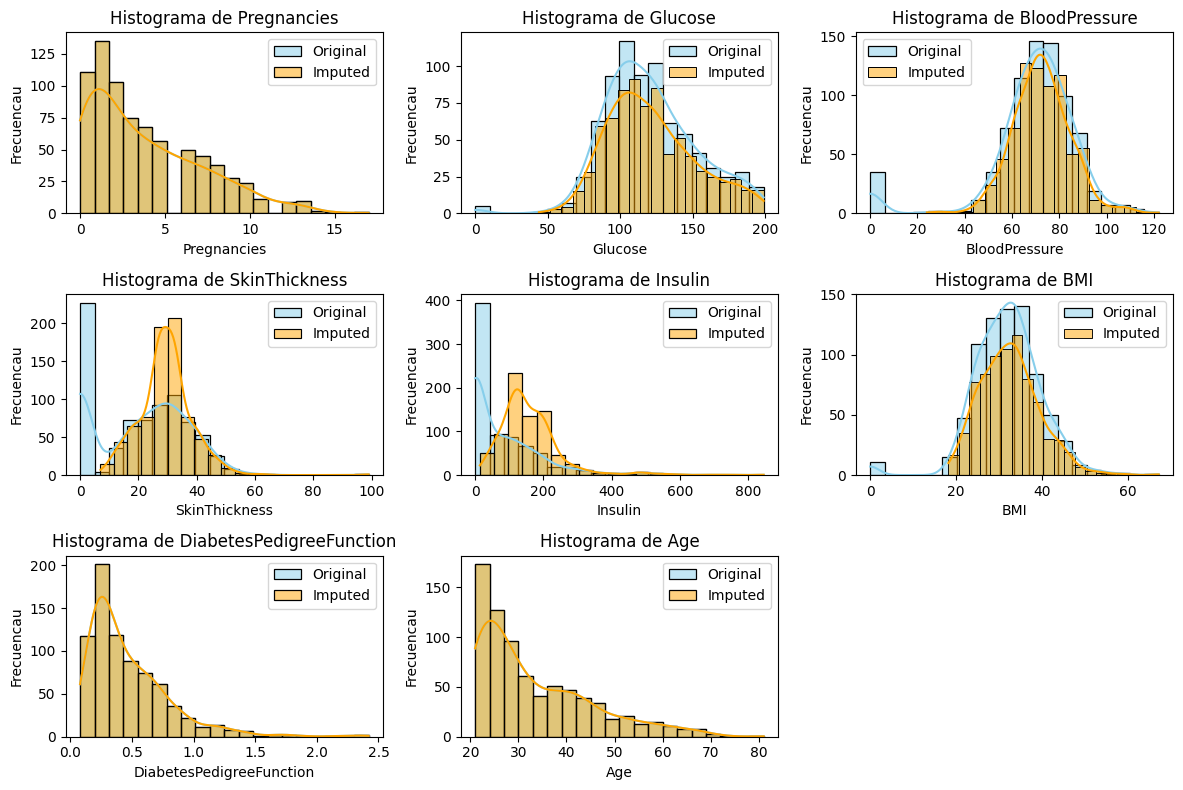

In [ ]:
# Lista de columnas a visulizar
columns_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos el histograma
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  
    
    # Histograma del dataframe original
    sns.histplot(df[column], kde=True, bins=20, color='skyblue', label='Original', alpha=0.5)
    
    # Histograma del dataframe imputado
    sns.histplot(data_imputed[column], kde=True, bins=20, color='orange', label='Imputed', alpha=0.5)
    
    plt.title(f'Histograma de {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Frecuencau', fontsize=10)
    plt.legend()  

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()
plt.show() 

# Coding Dojo visulizaciones avanzadas


No se identificaron outliers significativos ni en el dataset original ni en el dataset imputado. En la columna 'Pregnancies', los valores de 17 podrían no solo reflejar nacimientos, sino también embarazos que no llegaron a término. Además, podrían estar relacionados con factores culturales de la región o etnia de donde se tomaron las muestras, lo que hace que estos valores no deban ser descartados sin una evaluación más profunda.

De igual manera, los valores elevados de glucosa no deben ser descartados sin considerar el contexto. Dado que el test se realizó dos horas después de la ingestión de un suero glucosado, sería necesario contar con una escala de metabolización para determinar si los valores realmente están fuera del rango esperado.

## **Exploración de Datos:**

### **1. Visualizaciones univariadas y multivariadas:**

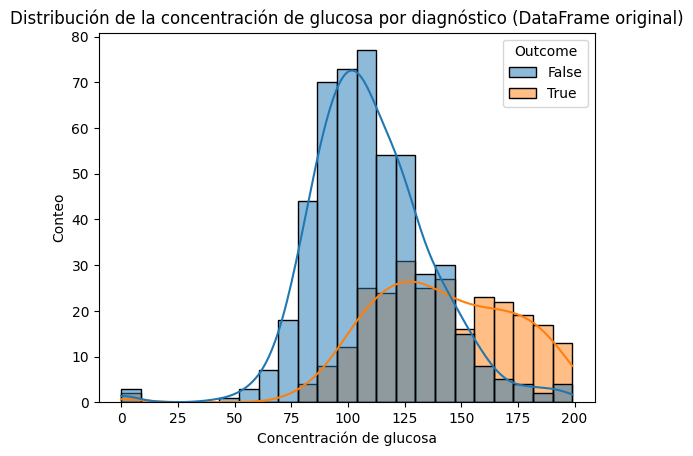

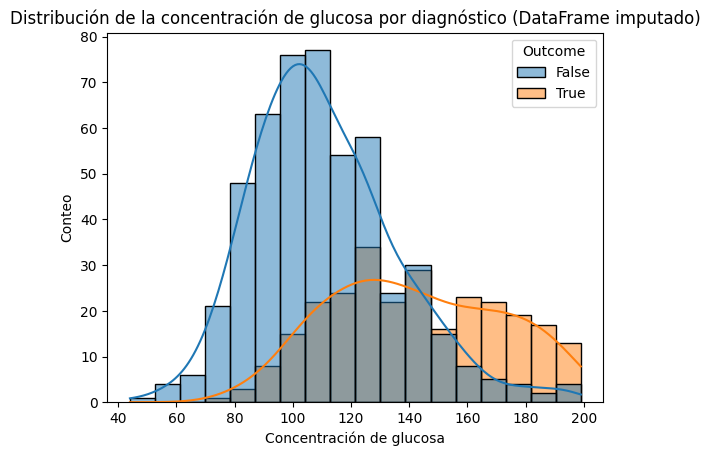

In [ ]:
# Histograma comparativo segun el diagnóstico en el DataFrame original
sns.histplot(data=df, x="Glucose", hue="Outcome", kde=True)
plt.title("Distribución de la concentración de glucosa por diagnóstico (DataFrame original)")
plt.xlabel("Concentración de glucosa")
plt.ylabel("Conteo")
plt.show()

# Histograma comparativo segun el diagnóstico en el DataFrame imputado (
sns.histplot(data=data_imputed, x="Glucose", hue="Outcome", kde=True)
plt.title("Distribución de la concentración de glucosa por diagnóstico (DataFrame imputado)")
plt.xlabel("Concentración de glucosa")
plt.ylabel("Conteo")
plt.show()

# Coding Dojo Visulizaciones abanzadas


Los niveles altos de glucosa son una señal fuerte de diabetes.Sinembargo, no todos los pacientes con diabetes tienen glucosa muy alta, es decir los niveles de glucosa varían bastante entre los pacientes diabéticos.
La imputación de datos no cambió las conclusiones generales. Los resultados son los esperamos un estudio sobre diabetes.

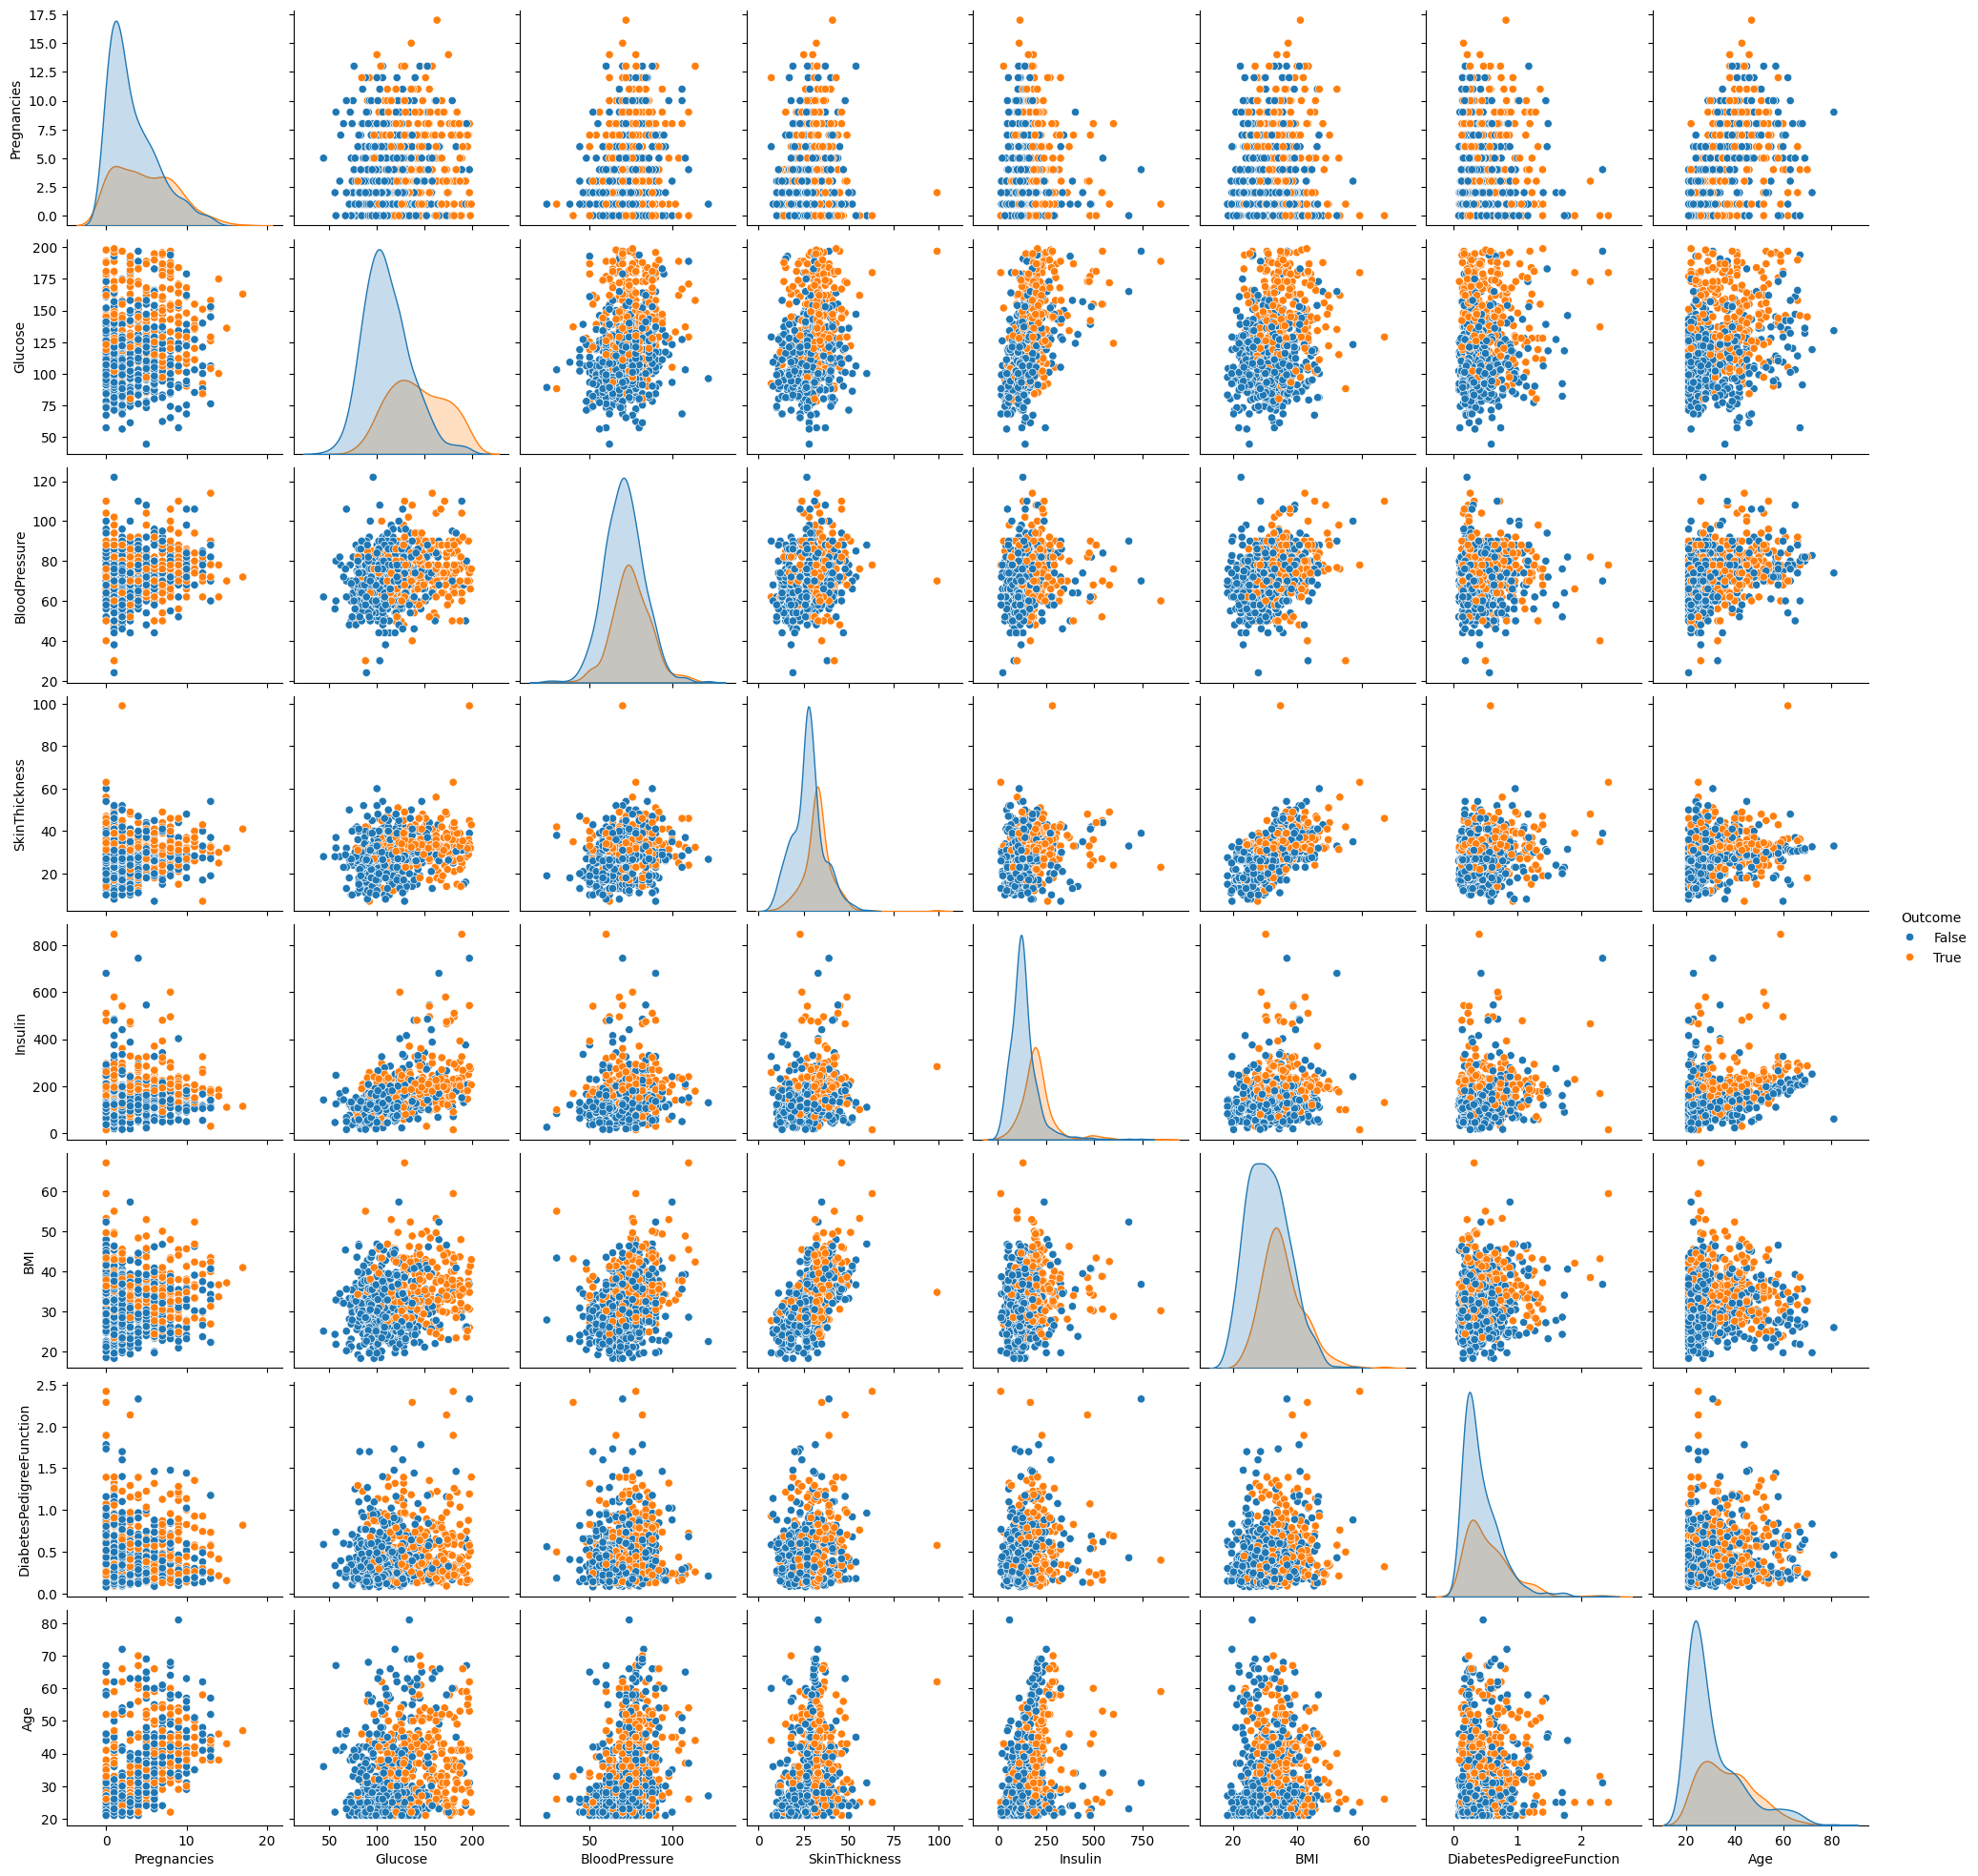

In [12]:
# Multivariate visualizations, como los valores no fueron afectados drasticamente por la imputacion, usamos el data_imputed para el grafico con mas de una variable. 
sns.pairplot(data_imputed, hue='Outcome')
plt.show()

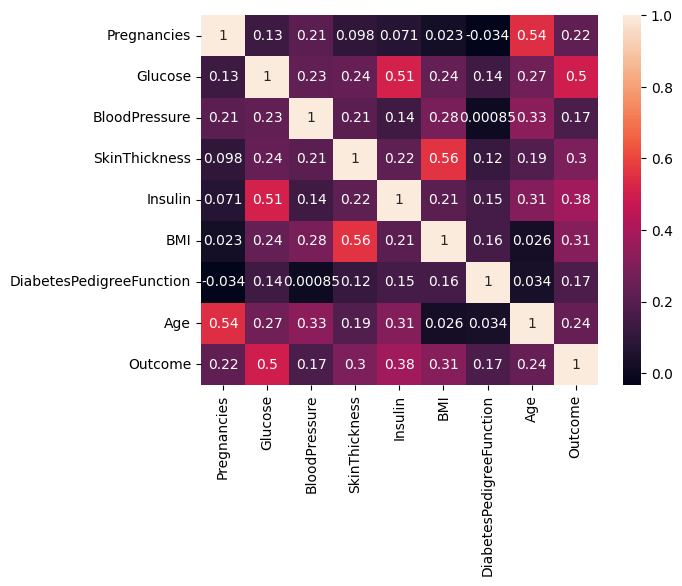

In [ ]:
# Correlation matrix
corr_matrix = data_imputed.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Coding Dojo Visulizaciones avanzadas

**Glucosa:** La glucosa tiene una fuerte correlación positiva con el BMI, la insulina y la edad. Esto es consistente con el conocimiento médico de que la obesidad, la resistencia a la insulina y la edad son factores de riesgo para la diabetes.

**BMI:** El BMI tiene una correlación positiva fuerte con la mayoría de las otras variables, lo que sugiere que la obesidad está asociada con muchos de los factores de riesgo para la diabetes.

**Outcome:** La variable "Outcome", que indica si una persona tiene diabetes o no, tiene correlaciones positivas con muchas de las otras variables, especialmente con la glucosa, el BMI y la edad. Esto confirma que estas variables son importantes predictores de la diabetes.

In [14]:
# Estidistica descriptiva de cada caracteristica del dataset
estadisticas_descriptivas = data_imputed.describe()
estadisticas_descriptivas

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.682815,72.384034,29.325383,159.000477,32.446279,0.471876,33.240885
std,3.369578,30.469813,12.117227,8.931387,90.642091,6.878612,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,109.682977,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.000000,140.000000,32.150000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,33.382629,194.545231,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


Glucosa, BMI y edad: Tienen valores promedio relativamente altos y una desviación estándar considerable, lo que sugiere una que el promedio no es muy representativo.
La mitad de los pacientes (50%) tienen diabetes (Outcome = 1).
Caracteristicas como la presión sanguínea, el SkinThickness y la insulina también muestran variabilidad, pero su interpretación puede requerir un análisis más profundo.
Caracteristicas como la glucosa, el BMI y la edad puedenestén relacionadas con el desarrollo de la diabetes, como lo indica los medicos.

## **Implementación de Modelos:**

**Entrenamos los modelos de Random Forest, XBG Boost, y Adaboots**


In [15]:
# Funcion para entrenar y evaluar el modelo
def train_and_evaluate(data, dataset_name):

    # Separar caracteristicas y target
    X = data.drop('Outcome', axis=1)
    y = data['Outcome']
    
    # Dividimos los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Definimos los modelos que vamos a entrenar
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }
    
    # Entrenar y evaluar los datos
    results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model_name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred)
        }
    return results


In [29]:
# Evaluamos ambos dataset
results_df = train_and_evaluate(df, "Original Dataset")
results_data_imputed = train_and_evaluate(data_imputed, "Imputed Dataset")

# Comparamos los resultados
def print_comparison(results1, results2, dataset1_name, dataset2_name):
    print(f"\n{'Metric':<12}{dataset1_name:<20}{dataset2_name:<20}")
    print("-" * 50)
    for model_name in results1:
        print(f"\nModel: {model_name}")
        for metric, value in results1[model_name].items():
            print(f"{metric:<12}{value:.4f}{results2[model_name][metric]:>20.4f}")

# Imprimimos los resultados
print_comparison(results_df, results_data_imputed, "DataSet Original", "DataSet Imputado")


# Codigo base, de Coding Dojo y clases. Chat GPT para unificar todo dentro de una funcion y limpiar el codigo.


Metric      DataSet Original    DataSet Imputado    
--------------------------------------------------

Model: Random Forest
Accuracy    0.7208              0.7792
Precision   0.6071              0.6667
Recall      0.6182              0.7636
F1-score    0.6126              0.7119
ROC-AUC     0.6980              0.7758

Model: XGBoost
Accuracy    0.7078              0.7987
Precision   0.5806              0.7069
Recall      0.6545              0.7455
F1-score    0.6154              0.7257
ROC-AUC     0.6960              0.7869

Model: AdaBoost
Accuracy    0.7338              0.8052
Precision   0.6250              0.7193
Recall      0.6364              0.7455
F1-score    0.6306              0.7321
ROC-AUC     0.7121              0.7919


**Evaluamos los modelos, vemos que modelo nos da resultados mas optimos**

In [30]:
def find_best_model(results):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
    best_models = {metric: None for metric in metrics}

    for metric in metrics:
        best_model = max(results.items(), key=lambda x: x[1][metric])
        best_models[metric] = {
            'Modelo': best_model[0],
            'Valor': best_model[1][metric]
        }
    return best_models

resultados_original = train_and_evaluate(df, "Dataset original")
resultados_imputed = train_and_evaluate(data_imputed, "Dataset imputado")

best_models_original = find_best_model(resultados_original)
best_models_imputed = find_best_model(resultados_imputed)


def display_best_models(best_models, dataset_name):
    print(f"\nEl mejor modelo para {dataset_name}")
    print("-" * 40)
    for metric, details in best_models.items():
        print(f"{metric:<12}: {details['Modelo']:<15} (Calificacion: {details['Valor']:.4f})")

display_best_models(best_models_original, "Dataset original")
display_best_models(best_models_imputed, "Dataset imputado")



El mejor modelo para Dataset original
----------------------------------------
Accuracy    : AdaBoost        (Calificacion: 0.7338)
Precision   : AdaBoost        (Calificacion: 0.6250)
Recall      : XGBoost         (Calificacion: 0.6545)
F1-score    : AdaBoost        (Calificacion: 0.6306)
ROC-AUC     : AdaBoost        (Calificacion: 0.7121)

El mejor modelo para Dataset imputado
----------------------------------------
Accuracy    : AdaBoost        (Calificacion: 0.8052)
Precision   : AdaBoost        (Calificacion: 0.7193)
Recall      : Random Forest   (Calificacion: 0.7636)
F1-score    : AdaBoost        (Calificacion: 0.7321)
ROC-AUC     : AdaBoost        (Calificacion: 0.7919)


AdaBoost es el mejor modelo en la mayoría de las métricas, especialmente en Precisión (Accuracy), Puntuación F1 (F1-score) y ROC-AUC en ambos datasets.
XGBoost es el segundo mejor modelo, superando a Random Forest en la mayoría de las métricas, particularmente en Recall y ROC-AUC.
Random Forest tiene un rendimiento significadtivo pero queda por detrás de AdaBoost y XGBoost en Precisión, Recall, F1-score y ROC-AUC.

**Optimatizamos los modemos y observamos los resultados**

In [31]:
# Optimizacion del dataset Imputad para evaluar la variacion
X = data_imputed.drop('Outcome', axis=1)
y = data_imputed['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Hiperparametos grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01]
}

In [33]:
# Cramos el modelo con GridSearchCV
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
xgb_model = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5, scoring='accuracy')
ada_model = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=5, scoring='accuracy')

# Entrenamos los modelos
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)

# Realizamos las predicciones
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
ada_preds = ada_model.predict(X_test)

In [ ]:
# Evaluamos los modelos, creamos una funcion para evaluar todos los modelos
def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}\n")

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)
evaluate_model("AdaBoost", y_test, ada_preds)


# Fuente: https://medium.com/latinxinai/automatizando-la-selecci%C3%B3n-de-modelos-y-el-ajuste-de-hiperpar%C3%A1metros-con-gridsearchcv-0ef095828cb8
# Codigo base en clase and ChatGPT para introduct todo el proceso en una funcion y limpieza de codigo

Model: Random Forest
Accuracy: 0.7922
Precision: 0.6825
Recall: 0.7818
F1-score: 0.7288
ROC-AUC: 0.7899

Model: XGBoost
Accuracy: 0.8117
Precision: 0.7241
Recall: 0.7636
F1-score: 0.7434
ROC-AUC: 0.8010

Model: AdaBoost
Accuracy: 0.7792
Precision: 0.6909
Recall: 0.6909
F1-score: 0.6909
ROC-AUC: 0.7596



Podemos ver un disminucion en el rendimiento de AdaBoost después de la optimización. Este comportamiento puede indicar de que AdaBoost no es tan sensible a los ajustes de hiperparámetros en este conjunto de datos. En modelos como XGBoost y Random Forest, la optimización ha mostrado mejoras más en varias métricas, lo que resalta que AdaBoost podría no ser el modelo más adecuado para este caso específico después de la optimización como lo quede ser en 1re Lugar XGBoots y en 2nd lugar Random Forest